In [1]:
#!/usr/bin/env python
# coding: utf-8
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import time
import numpy as np
from datetime import datetime
from sklearn.externals import joblib 
import os
from konlpy.tag import Mecab
import lightgbm as lgb
print(lgb.__version__)

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import StratifiedKFold

import gc

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings(action='ignore')


import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from tools import eval_summary

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
device

/home/aiden/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


2.3.2
1.3.1
GeForce RTX 2070 SUPER
True


device(type='cuda', index=0)

In [2]:
print(os.getcwd())

base_path = '.'

df_train = pd.read_csv(os.path.join(base_path , 'input/train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join(base_path , 'input/public_test.csv'), index_col=0)
df_test['smishing'] = -1

df_fea = pd.concat([df_train, df_test])
df_fea.shape

/home/aiden/src/dacon_14


(297571, 3)

In [3]:
train_size = len(df_train)
print(train_size)

# cat_cols = []
# fea_cols = tfidf_cols + cat_cols + cnt_cols
# fea_cols = cnt_cols + cat_cols
# fea_cols = tfidf_cols + cat_cols
# len(fea_cols)

295945


#### Load Data

In [4]:
# merged_ts = '20191231T113708_5499'
# merged_ts = '20191231T162533_2022'
# merged_ts = '20191231T165424_6099'
# merged_ts = '20191231T111228_8180'
# merged_ts = '20200101T184353_5853'
# merged_ts = '20200102T005929_6546_128_49980' # 984
# merged_ts = '20200102T015155_8438_128_49980' # 986
# merged_ts = '20200102T160226_8438_275_997'
merged_ts = '20200104T033010_10938_512_49980'


train_path = 'data/df_merged_{}_train.pkl'.format(merged_ts)
test_path = 'data/df_merged_{}_test.pkl'.format(merged_ts)
dict_path = 'data/df_merged_{}_fea_dict.pkl'.format(merged_ts)

df_model = joblib.load(train_path)  
df_test = joblib.load(test_path) 
fea_dict = joblib.load(dict_path)

print('model_set\n', df_model['smishing'].value_counts())

model_set
 0    277242
1     18703
Name: smishing, dtype: int64


In [5]:
seq_cols = ['seq_' + str(i) for i in range(512)]
idx_col = [c for c in df_model.columns if '_idx' in c][0]

In [6]:
# df_model[seq_cols] = pd.DataFrame(df_model[idx_col].values.tolist(), df_model.index, dtype=np.int16)
# df_test[seq_cols] = pd.DataFrame(df_model[idx_col].values.tolist(), df_model.index, dtype=np.int16)

In [7]:
df_model.drop(idx_col, axis=1, inplace=True)
df_test.drop(idx_col, axis=1, inplace=True)

In [8]:
fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', idx_col]]
cat_cols = [c for c in fea_cols if 'seq_' in c]

len(fea_cols), len(cat_cols)

(10937, 0)

In [9]:
gc.collect()

100

#### Params

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

model_ts = datetime.now().strftime('%Y%m%dT%H%M%S')

initscore_filename = ''
params = {
    'boosting':'gbdt',
#     'boosting':'dart',
    'num_leaves': 7, 
#     'max_depth': 5,
    'objective': 'binary',
    'metric':'auc',
    'num_threads': 16,
    'learning_rate': 0.005,
#     'is_unbalance': True,
    'scale_pos_weight':200,
    'bagging_fraction':0.5,
    'bagging_freq':10,
    'feature_fraction':0.5,
    'initscore_filename':initscore_filename,
#     'lambda_l1':200,
#     'lambda_l2':2000,
#     'device_type':'gpu',
}

data_params = {
    'max_bin':128,
#     'enable_bundle': False,
}
num_round = 11000



In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295945 entries, 0 to 336378
Columns: 10938 entries, smishing to tfidf_pos_word_22_0999
dtypes: float16(10893), int16(44), int64(1)
memory usage: 6.0 GB


In [12]:
df_model = df_model.reset_index()
df_model

,id,smishing,fea__EC,fea__EF,fea__EP,fea__ETM,fea__ETN,fea__IC,fea__JC,fea__JKB,...,tfidf_pos_word_22_0990,tfidf_pos_word_22_0991,tfidf_pos_word_22_0992,tfidf_pos_word_22_0993,tfidf_pos_word_22_0994,tfidf_pos_word_22_0995,tfidf_pos_word_22_0996,tfidf_pos_word_22_0997,tfidf_pos_word_22_0998,tfidf_pos_word_22_0999
0,0,0,0,2,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,1,2,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,2,5,4,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,1,5,5,7,2,0,1,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,2,1,1,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295940,336373,0,5,4,8,7,2,0,2,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295941,336375,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295942,336376,0,5,2,3,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
295943,336377,0,3,2,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Train

In [13]:
print('merged_ts', merged_ts, 'model_ts', model_ts)
print(params)
print(data_params)
pred_csv = []
fea_size = -1
try_cnt = 1


for t in tqdm_notebook(range(try_cnt), total=try_cnt, desc = 'Try'):
    fea_cols = [c for c in df_model.columns if c not in ['smishing', 'id', 'score']]
    
    if fea_size > 0:
        fea_cols = list(set(np.random.choice(fea_cols, fea_size)))
        print(t, len(fea_cols), fea_cols[:100])
    else:
        print(t, len(fea_cols))

    [df_model.drop(c, axis=1, inplace=True) for c in df_model.columns if 'smishing_' in c]
    [df_test.drop(c, axis=1, inplace=True) for c in df_test.columns if 'smishing_' in c]

#     X = df_model[fea_cols].values
#     y = df_model['smishing'].values

    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, random_state=8405)
    cnt = 0
    
#     train_data = lgb.Dataset(X, label=y, feature_name=fea_cols, categorical_feature=cat_cols, 
#                              free_raw_data=False, params=data_params)

    # for train_index, valid_index in skf.split(X, y):
    for train_index, valid_index in tqdm_notebook(skf.split(df_model['id'].values, df_model['smishing'].values), total=n_splits, desc = 'CV'):
#         cnt = cnt + 1
        print('\n', t, '*' * 20, cnt, '*' * 20)
        
        train_set = lgb.Dataset(df_model.loc[train_index, fea_cols].values, 
                                 label=df_model.loc[train_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)
        
        valid_set = lgb.Dataset(df_model.loc[valid_index, fea_cols].values, 
                                 label=df_model.loc[valid_index, 'smishing'].values, 
                                 feature_name=fea_cols, categorical_feature=cat_cols, 
                                 free_raw_data=True, params=data_params)

#         train_set = train_data.subset(train_index, params=data_params).construct()
#         valid_set = train_data.subset(valid_index, params=data_params).construct()
        print('train_set', np.unique(train_set.get_label(), return_counts=True))
        print('valid_set', np.unique(valid_set.get_label(), return_counts=True))

        bst = lgb.train(params, train_set, num_round, categorical_feature=cat_cols,
                        early_stopping_rounds=300, 
                        valid_sets=[train_set, valid_set],
                        verbose_eval=200,
                        # init_model=init_model,
                       )
        
        pred_tag = 'smishing_{}_{}__{}'.format(t, cnt, bst.best_iteration)
        print('pred_tag', pred_tag, 'Best Iteration:', bst.best_iteration)

        renamed_cols = [fea_dict[c] if c in fea_dict.keys() else c for c in fea_cols]

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='split'))}
        print('<split>', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_split.pkl'.format(model_ts, pred_tag))

        impt_dict = {k:v for k, v in zip(renamed_cols, bst.feature_importance(importance_type='gain'))}    
        print('<gain>\n', sorted(impt_dict.items(), key=(lambda x:x[1]), reverse=True)[:5])
        joblib.dump(impt_dict, 'model/{}_{}_gain.pkl'.format(model_ts, pred_tag))

        df_model['score'] = bst.predict(df_model[fea_cols].values)    
        df_model[['score']].to_csv('submit/{}_{}_lgb_score.csv'.format(model_ts, pred_tag), index=True)
        print('model\n', eval_summary(df_model['smishing'].values, df_model['score'].values, cut_off=0.5))
        
        df_test['smishing'] = bst.predict(df_test[fea_cols].values)    
        df_test[['smishing']].to_csv('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag), index=True)
        pred_csv.append('submit/{}_{}_lgb.csv'.format(model_ts, pred_tag))
        
        del train_set, valid_set
        gc.collect()


merged_ts 20200104T033010_10938_512_49980 model_ts 20200104T040724
{'boosting': 'gbdt', 'num_leaves': 7, 'objective': 'binary', 'metric': 'auc', 'num_threads': 16, 'learning_rate': 0.005, 'scale_pos_weight': 200, 'bagging_fraction': 0.5, 'bagging_freq': 10, 'feature_fraction': 0.5, 'initscore_filename': ''}
{'max_bin': 128}


0 10937



 0 ******************** 1 ********************
train_set (array([0, 1]), array([221793,  14962]))
valid_set (array([0, 1]), array([55449,  3741]))
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.99991	valid_1's auc: 0.999703
[400]	training's auc: 0.999995	valid_1's auc: 0.999803
[600]	training's auc: 0.999998	valid_1's auc: 0.999891
[800]	training's auc: 0.999999	valid_1's auc: 0.999938
[1000]	training's auc: 0.999999	valid_1's auc: 0.999964
[1200]	training's auc: 1	valid_1's auc: 0.999977
[1400]	training's auc: 1	valid_1's auc: 0.999986
[1600]	training's auc: 1	valid_1's auc: 0.99999
[1800]	training's auc: 1	valid_1's auc: 0.999992
[2000]	training's auc: 1	valid_1's auc: 0.999993
[2200]	training's auc: 1	valid_1's auc: 0.999994
[2400]	training's auc: 1	valid_1's auc: 0.999995
[2600]	training's auc: 1	valid_1's auc: 0.999997
[2800]	training's auc: 1	valid_1's auc: 0.999997
[3000]	training's auc: 1	valid_1's auc: 0.999998
[3200]	training's auc: 1	v

[3000]	training's auc: 1	valid_1's auc: 0.999974
[3200]	training's auc: 1	valid_1's auc: 0.999974
[3400]	training's auc: 1	valid_1's auc: 0.999974
[3600]	training's auc: 1	valid_1's auc: 0.999975
[3800]	training's auc: 1	valid_1's auc: 0.999975
[4000]	training's auc: 1	valid_1's auc: 0.999976
[4200]	training's auc: 1	valid_1's auc: 0.999976
[4400]	training's auc: 1	valid_1's auc: 0.999976
[4600]	training's auc: 1	valid_1's auc: 0.999976
Early stopping, best iteration is:
[4350]	training's auc: 1	valid_1's auc: 0.999976
pred_tag smishing_0_5__4350 Best Iteration: 4350
<split> [('tfidf_pos_word_22_0066_xxx 은행', 915), ('tfidf_pos_char_11_0000_ ', 480), ('tfidf_word_11_1574_올림', 430), ('cnt_0126_금', 288), ('tfidf_word_11_0385_광고', 284)]
<gain>
 [('cnt_0715_자', 8746285.863495275), ('fea__NNG', 8121328.632161468), ('fea__noun_cnt', 4388111.176655725), ('cnt_0126_금', 1897787.350112155), ('tfidf_word_11_1574_올림', 926982.2932132259)]
model
 {'auc': 0.9999984247647125, 'confusion_matrix': array(

In [14]:
# y_true = df_model['smishing'].values
# y_score = df_model[[c for c in df_model.columns if 'smishing_' in c]].mean(axis=1)

# print('agg model\n', eval_summary(y_true, y_score, cut_off=0.5))

In [15]:
# df_model[(y_score <= 0.5) & (y_true == 1)]['text']

In [16]:
# df_model[(y_score > 0.5) & (y_true == 0)]['text']

In [17]:
print(len(pred_csv))

df_submit = pd.concat([pd.read_csv(csv, index_col=0) for csv in pred_csv], axis=1)

5


In [18]:
df_submit = df_test[['smishing']]
df_submit['smishing'] = 0
for csv in pred_csv:
    print(csv)
    df = pd.read_csv(csv, index_col=0)
    df_submit['smishing'] = df_submit['smishing'] + df['smishing']
    c = csv.split('__')[0][-1]
    df_submit['smishing_{}'.format(c)] = df['smishing']
#     display(df.head())
df_submit['smishing'] = df_submit['smishing'] / len(pred_csv)

submit/20200104T040724_smishing_0_1__4292_lgb.csv
submit/20200104T040724_smishing_0_2__4174_lgb.csv
submit/20200104T040724_smishing_0_3__3860_lgb.csv
submit/20200104T040724_smishing_0_4__2457_lgb.csv
submit/20200104T040724_smishing_0_5__4350_lgb.csv


In [31]:
pred_cols = [c for c in df_submit.columns if 'smishing_' in c]
# pred_cols.remove('smishing_1')
# pred_cols.remove('smishing_2')
df_submit['std'] = df_submit[pred_cols].std(axis=1)
df_submit['median'] = df_submit[pred_cols].median(axis=1)

In [32]:
df_std = df_submit[df_submit['std'] < 1]
print(df_std.shape)
df_std.sort_values('std', ascending=False).head(30)

(1626, 8)


,smishing,smishing_1,smishing_2,smishing_3,smishing_4,smishing_5,std,median
id,,,,,,,,
341227,0.628679,0.462020,0.834005,0.938520,0.875227,0.033620,0.381057,0.834005
340275,0.484184,0.063221,0.206667,0.546858,0.637444,0.966731,0.358641,0.546858
340276,0.488110,0.064195,0.218316,0.551729,0.639578,0.966731,0.356567,0.551729
340046,0.441105,0.043838,0.355065,0.218618,0.938827,0.649176,0.355579,0.355065
341104,0.506147,0.145574,0.470425,0.803222,0.880985,0.230528,0.330156,0.470425
340597,0.617719,0.244174,0.291368,0.731410,0.927540,0.894101,0.328384,0.731410
340285,0.563589,0.161865,0.405092,0.472976,0.778113,0.999897,0.328291,0.472976
341000,0.291396,0.030617,0.070628,0.279606,0.818338,0.257792,0.314515,0.257792
340259,0.432313,0.094050,0.203967,0.352268,0.800637,0.710641,0.310685,0.352268


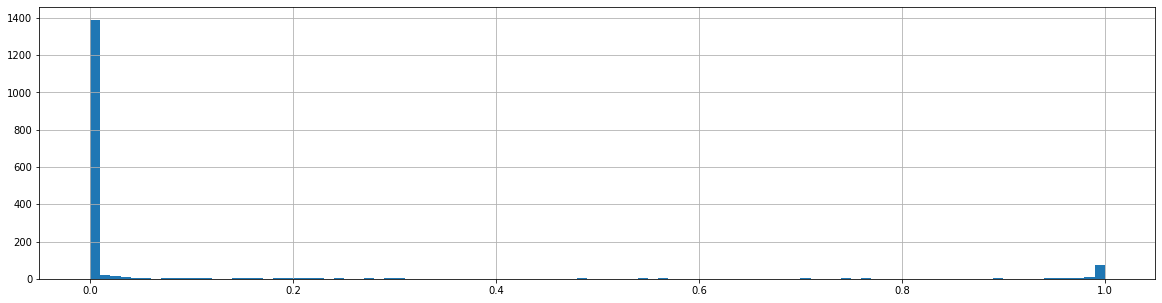

In [33]:
df_submit['smishing'].hist(bins=100, figsize=(20, 5))

In [34]:
(df_submit['smishing'] * 10).astype(int).value_counts(sort=False)

0    1451
1      20
2      18
3       7
4       5
5       8
6       5
7      12
8       5
9      95
Name: smishing, dtype: int64

In [35]:
print(model_ts)
df_submit[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)

20200104T040724


In [24]:
# print(len(pred_cols))
# df_test['pred_max'] = df_test[pred_cols].max(axis=1)
# df_test['pred_min'] = df_test[pred_cols].min(axis=1)
# df_test['pred_mean'] = df_test[pred_cols].mean(axis=1)
# df_test['pred_std'] = df_test[pred_cols].std(axis=1)

# print(df_test['pred_std'].max(), df_test['pred_std'].min(), df_test['pred_std'].mean())

# df_test['smishing'] = df_test['pred_mean']

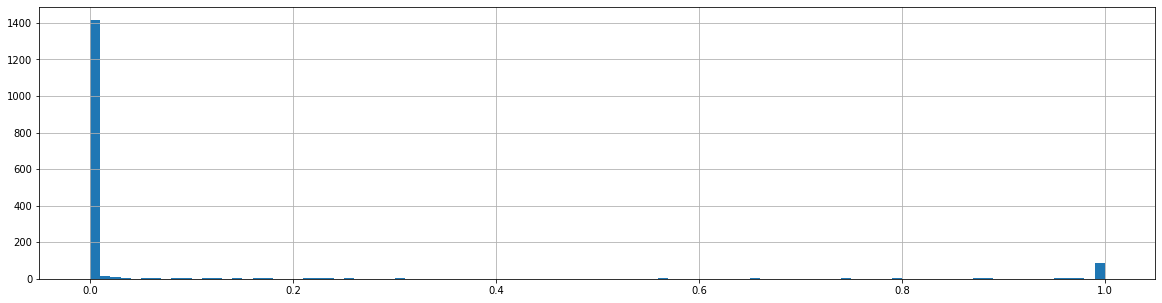

In [25]:
df_test['smishing'].hist(bins=100, figsize=(20, 5))

In [26]:
(df_test['smishing'] * 10).astype(int).value_counts(sort=False)

0    1462
1      12
2      15
3       5
4       5
5       5
6       3
7       7
8      10
9     102
Name: smishing, dtype: int64

In [27]:
# for c in pred_cols:
#     print(c)
#     display((df_test[c] * 10).astype(int).value_counts(sort=False))

In [28]:
model_ts

'20200104T040724'

In [29]:
df_test['smishing'] = df_test['smishing']
df_test[['smishing']].to_csv('submit/{}.csv'.format(model_ts), index=True)


In [30]:
# df_test['smishing'] = df_test['pred_mean']
# df_test[['smishing']].to_csv('submit/{}_lgb.csv'.format(model_ts), index=True)
# # df_test[['id', 'smishing', 'text']].sort_values('smishing', ascending=False).to_csv('{}_text.csv'.format(model_ts), index=False)
